# Train an image classifire using Keras ImageDataGenerator
Datasets: cats vs dogs, caltech birds

In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download datasets

# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Download pretrained models and training histories
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2023-10-19 13:11:24--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  31.0MB/s    in 30s     

2023-10-19 13:11:54 (26.2 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2023-10-19 13:11:54--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125947

In [4]:
# preparing data

cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [5]:
# put all bird images in a single class

raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


Sample cat image:


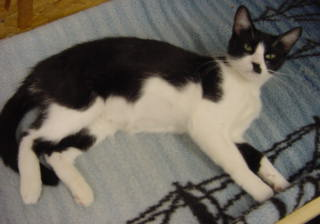


Sample dog image:


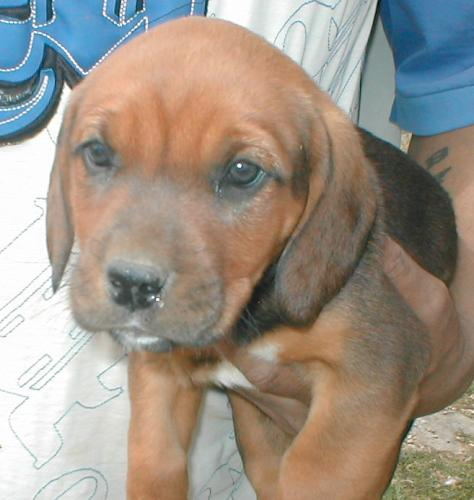


Sample bird image:


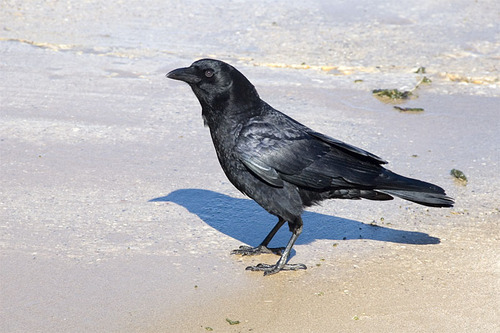

In [6]:
# checking data
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

# Data Cleaning

In [7]:
# removing null images
!find /tmp/data/ -size 0 -exec rm {} +

# removing non jpg files
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

# Train / Test Split

In [8]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

# Move 70% of the images to the train dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# Move the remaining images to the eval dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8749 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3750 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


# Selecting and Training the CNN Model
Keras' ImageDataGenerator is used. It has built-in functionalities to easily feed your model with raw, rescaled or even augmented image data.

In [9]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # A simple CNN architecture based on the one found here: https://www.tensorflow.org/tutorials/images/classification
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a model
model = create_model()

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

Found 25749 images belonging to 3 classes.
Found 11037 images belonging to 3 classes.


In [15]:
# Training

model_trained = model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=50,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/50
100/100 [==============================] - 30s 178ms/step - loss: 1.0368 - sparse_categorical_accuracy: 0.4350 - val_loss: 0.8892 - val_sparse_categorical_accuracy: 0.5355
Epoch 2/50
100/100 [==============================] - 13s 133ms/step - loss: 0.8233 - sparse_categorical_accuracy: 0.5950 - val_loss: 0.7962 - val_sparse_categorical_accuracy: 0.6090
Epoch 3/50
100/100 [==============================] - 15s 150ms/step - loss: 0.7591 - sparse_categorical_accuracy: 0.6366 - val_loss: 0.7439 - val_sparse_categorical_accuracy: 0.6270
Epoch 4/50
100/100 [==============================] - 21s 213ms/step - loss: 0.6885 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.6684 - val_sparse_categorical_accuracy: 0.6801
Epoch 5/50
100/100 [==============================] - 18s 184ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.6526 - val_sparse_categorical_accuracy: 0.6816
Epoch 6/50
100/100 [==============================] - 14s 139ms/step - loss: 0.6368 -

# Model evaluation
Although model accuracy is not that bad, plots show a large gap between train and test graphs. and thus, overfitting. One solution is adding a dropout layer, but I keep the model same and pply data augmentation.

In [43]:
def get_training_metrics(model):

  model = model.history

  acc = model['sparse_categorical_accuracy']
  val_acc = model['val_sparse_categorical_accuracy']

  loss = model['loss']
  val_loss = model['val_loss']

  return acc, val_acc, loss, val_loss

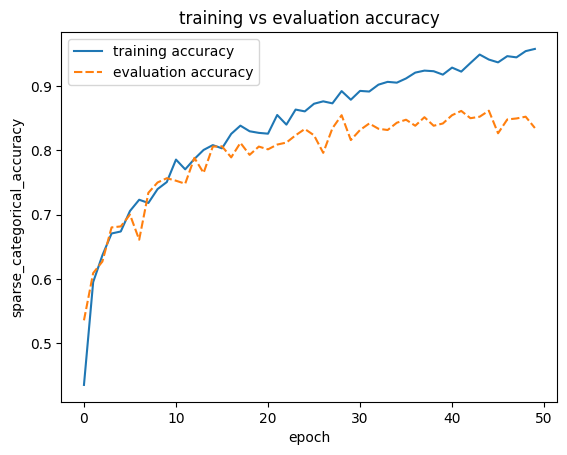

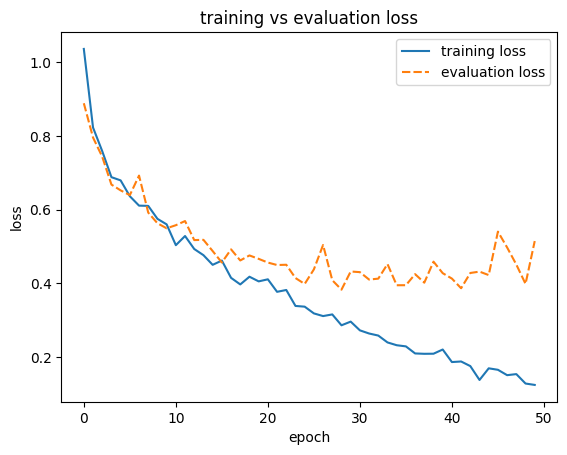

In [44]:
def plot_train_eval(model):
  acc, val_acc, loss, val_loss = get_training_metrics(model)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()



plot_train_eval(model_trained)

# Additional Evaluation Metrics

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse',
    shuffle=False)

# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions = model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred = np.argmax(predictions, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {accuracy_score(y_true, y_pred)}")

Found 11037 images belonging to 3 classes.
345/345 [==============================] - 24s 70ms/step
Accuracy Score: 0.839630334329981
Balanced Accuracy Score: 0.839630334329981


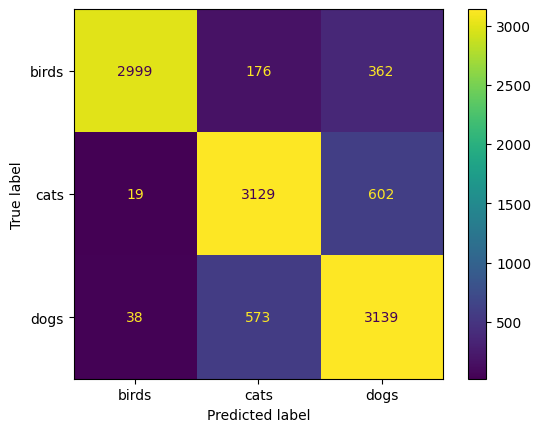

In [20]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

# Training with Data Augmentation
It helps to avoid overfitting.

In [27]:
augmented_model = create_model()

# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse')

Found 25749 images belonging to 3 classes.
Found 11037 images belonging to 3 classes.


# Checking Augmentation procedure


Transformation number: 0



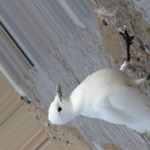


Transformation number: 1



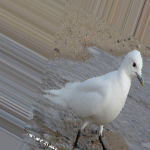


Transformation number: 2



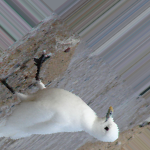


Transformation number: 3



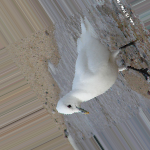

In [30]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in the training partition
def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.3,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

In [31]:
augmented_history = augmented_model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=80,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/80
100/100 [==============================] - 36s 329ms/step - loss: 0.9997 - sparse_categorical_accuracy: 0.4650 - val_loss: 0.8226 - val_sparse_categorical_accuracy: 0.5832
Epoch 2/80
100/100 [==============================] - 29s 291ms/step - loss: 0.8774 - sparse_categorical_accuracy: 0.5500 - val_loss: 0.7926 - val_sparse_categorical_accuracy: 0.6242
Epoch 3/80
100/100 [==============================] - 28s 284ms/step - loss: 0.8074 - sparse_categorical_accuracy: 0.6031 - val_loss: 0.7623 - val_sparse_categorical_accuracy: 0.6203
Epoch 4/80
100/100 [==============================] - 33s 332ms/step - loss: 0.7735 - sparse_categorical_accuracy: 0.6206 - val_loss: 1.1405 - val_sparse_categorical_accuracy: 0.5301
Epoch 5/80
100/100 [==============================] - 28s 284ms/step - loss: 0.7583 - sparse_categorical_accuracy: 0.6300 - val_loss: 0.9927 - val_sparse_categorical_accuracy: 0.5445
Epoch 6/80
100/100 [==============================] - 28s 284ms/step - loss: 0.7190 -

# Augmented model Evaluation
Evaluation accuracy follows more closely the training one. So **the model is no longer overfitting**.

It is worth mentioning that this model achieves a slightly lower evaluation accuracy and higher loss when compared to the model without data augmentation. The reason for this, is that this model needs more epochs to train. To spot this issue, check that for the model without data augmentation, the training accuracy reached almost 1, whereas the augmented one can still improve.

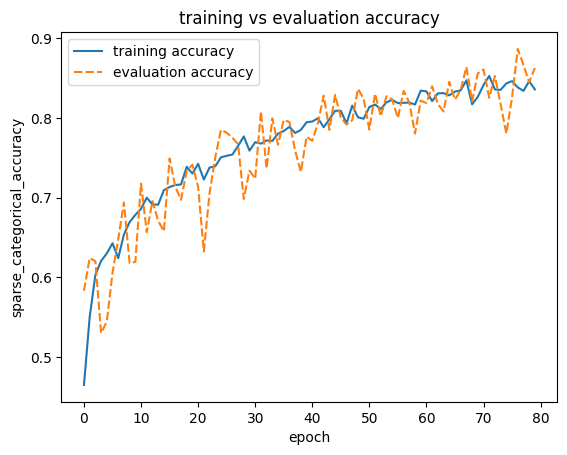

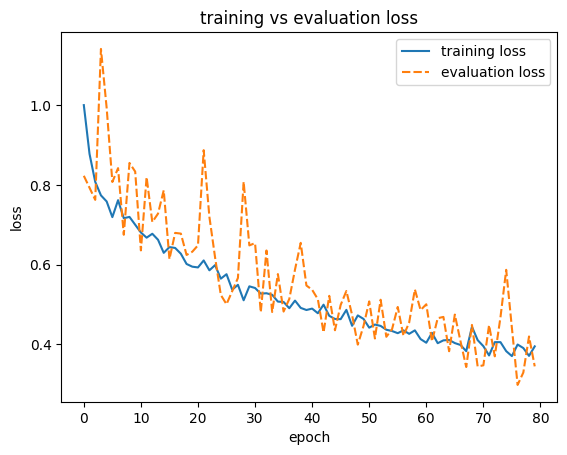

In [45]:
plot_train_eval(augmented_history)